## MESA lab: An exploration in agent-based models using forest fire simulation

The Python package MESA aids in the modeling, analysis, and visualization of agent-based data, making it a perfect candidate for use in modeling forest fires. 

An agent based model requires agents as well as an environment for the agents to interact with. Here, we'll define trees as agents, and disperse them into a grid with a user-defined density. 

Wind is one of the largest influences on forest fire spread. In Tom Beer's study, *the Interaction of Wind and Fire* http://link.springer.com/article/10.1007%2FBF00183958 he explains how and why fire spreads so much faster during unstable wind conditions. We use the windspeeds in his work to impose conditions for fire spread on the agents. This is done using MESA's Moore neighborhood argument, a boolean that identifies the eight neighbors around a cell. 

Import the necessary modules: 

In [149]:
import random
from numpy.random import uniform
from numpy import multiply
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import Grid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner
from numpy import multiply
from scipy.ndimage.filters import gaussian_filter

import pandas as pd
import matplotlib.cm as cm
from math import pi

Define the agents (trees). Give them a position in the grid, and using an if/else statement, say whether or not their neighbors will catch fire if they are on fire. -Again, this requires the Moore's neighborhood argument, as well as a defined range of windspeeds and radius of fire spread.  

In [151]:
class TreeCell(Agent):
    '''
    A tree cell.
    
    Attributes:
        x, y: Grid coordinates
        condition: Can be "Fine", "On Fire", or "Burned Out"
        unique_id: (x,y) tuple. 
    
    unique_id isn't strictly necessary here, but it's good practice to give one to each
    agent anyway.
    '''
    def __init__(self, model, pos):
        '''
        Create a new tree.
        Args:
            pos: The tree's coordinates on the grid. Used as the unique_id
        '''
        super().__init__(pos, model)
        self.pos = pos
        self.unique_id = pos
        self.condition = "Fine"
        
    def step(self):
        '''
        If windspeed is under 2, only immediate neighbors with a common edge catch fire.
        If windspeed is between 2 and 6, all neighbors in Moore's neighborhood catch fire.
        If windspeed is 6 or greater, Moore's neighbors within a radius of 2 squares catch fire.
        '''
        if self.condition == "On Fire":
            if 2 <= self.model.wind < 6: 
                neighbors = self.model.grid.get_neighbors(self.pos, moore = True)
            elif self.model.wind >= 6:
                neighbors = self.model.grid.get_neighbors(self.pos, radius = 2, moore = True)
            else:
                neighbors = self.model.grid.get_neighbors(self.pos, moore = False)
            for neighbor in neighbors:
                if neighbor.condition == "Fine":
                    neighbor.condition = "On Fire"
            self.condition = "Burned Out"

Now we can start the model, this will initiate a simulated forest based on a user-defined tree density. Arguments for the wind speed, and size of the grid are also needed. The model also includes a step function to prevent silly occurances like a tree catching fire over and over again, and to stop the model from running if all of the trees burn down. 

In [136]:
class ForestFire(Model):
    '''
    Simple Forest Fire model.
    '''
    def __init__(self, height, width, density, wind):
        '''
        Create a new forest fire model.
        
        Args:
            height, width: The size of the grid to model
            density: What fraction of grid cells have a tree in them.
        '''
        # Initialize model parameters
        self.height = height
        self.width = width
        self.density = density
        self.wind = wind
        
        # Set up model objects
        self.schedule = RandomActivation(self)
        self.grid = Grid(height, width, torus=False)
        self.dc = DataCollector({"Fine": lambda m: self.count_type(m, "Fine"),
                                "On Fire": lambda m: self.count_type(m, "On Fire"),
                                "Burned Out": lambda m: self.count_type(m, "Burned Out")})
        
        # Place a tree in each cell with Prob = density
        for x in range(self.width):
            for y in range(self.height):
                if random.random() < self.density:
                    # Create a tree
                    new_tree = TreeCell(self, (x, y))
                    # Set all trees in the first column on fire.
                    if x == 0:
                        new_tree.condition = "On Fire"
                    self.grid[x][y] = new_tree
                    self.schedule.add(new_tree)
        self.running = True
        
    def step(self):
        '''
        Advance the model by one step.
        '''
        self.schedule.step()
        self.dc.collect(self)
        # Halt if no more fire
        if self.count_type(self, "On Fire") == 0:
            self.running = False
            
    @staticmethod
    def count_type(model, tree_condition):
        '''
        Helper method to count trees in a given condition in a given model.
        '''
        count = 0
        for tree in model.schedule.agents:
            if tree.condition == tree_condition:
                count += 1
        return count


Now we're ready to run the simulation. I'm especially interested in what will happen if we increase only the wind parameter. How much more of the forest will burn if it's slightly windier? So starting off, we have a 200 x 200 grid with a tree density of 0.4, and an initial windspeed of 3. 

In [152]:
fire = ForestFire(200, 200, 0.4, 3)
fire.run_model()

I'm going to add a variable called *Burn Fraction* to the table of results (The data frame that tells us how many trees have burned down, are fine, or are on fire in a given timestep). This will give us an idea of how much of the forest was gone throughout the iterations of the model. This, along with some visuals, will give us something to compare between this model, with a windspeed of 3, and a model with a higher windspeed. 

In [153]:
results = fire.dc.get_model_vars_dataframe()
results['Burn Fraction'] = (results['Burned Out']/(results['Burned Out']+results['Fine']+results['On Fire']))
results.head()

,Burned Out,Fine,On Fire,Burn Fraction
0,144,15834,75,0.008970
1,274,15720,59,0.017068
2,356,15644,53,0.022177
3,449,15553,51,0.027970
4,522,15500,31,0.032517


Looking at the tail of the results we can see how many timesteps we moved through before the fire burnt out. (When I ran the code, it resulted in 114 timesteps and a burn fraction of about 20%.)

In [154]:
results.tail()

,Burned Out,Fine,On Fire,Burn Fraction
110,3206,12837,10,0.199713
111,3219,12831,3,0.200523
112,3223,12829,1,0.200772
113,3226,12826,1,0.200959
114,3227,12826,0,0.201022


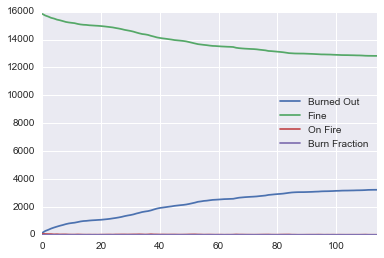

In [157]:
results.plot()

Plotting the burn fraction shows a steady increase that levels out as the timesteps near their end. -Just as we would expect. 

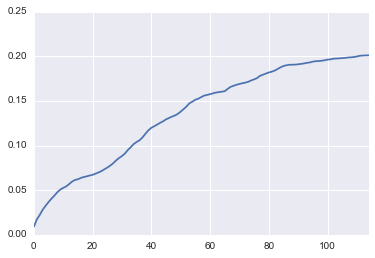

In [155]:
burn = results['Burn Fraction'].plot()

If we go through the locations grid and assign each cell that has a burned tree in it a count, we can map the burned area. -Burned trees are in black. The next map shows the inverse map, the trees that are fine. I've included the inverse map because I think it's interesting to see there are single trees still standing in places that otherwise burned down, a phenomena that happens in real life. 

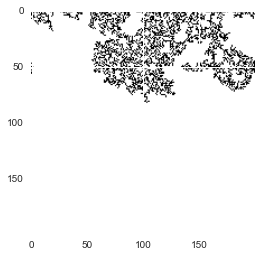

In [158]:
treeCounts = np.zeros((fire.grid.width, fire.grid.height))
for cell in fire.grid.coord_iter():
    cell_content, x, y = cell
    try:
        if cell[0].condition == "Burned Out":
            treeCount = 1
    except:
        treeCount = 0
    treeCounts[x][y] = treeCount
trees = plt.imshow(treeCounts)

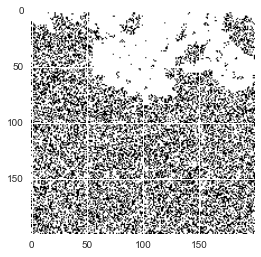

In [159]:
treeCounts = np.zeros((fire.grid.width, fire.grid.height))
for cell in fire.grid.coord_iter():
    cell_content, x, y = cell
    try:
        if cell[0].condition == "Fine":
            treeCount = 1
    except:
        treeCount = 0
    treeCounts[x][y] = treeCount
trees = plt.imshow(treeCounts)

Now we run the model again, this time doubling the windspeed to see how it effects fire spread. 

In [160]:
fire = ForestFire(200, 200, 0.4, 6)
fire.run_model()

In [161]:
results = fire.dc.get_model_vars_dataframe()
results['Burn Fraction'] = (results['Burned Out']/(results['Burned Out']+results['Fine']+results['On Fire']))

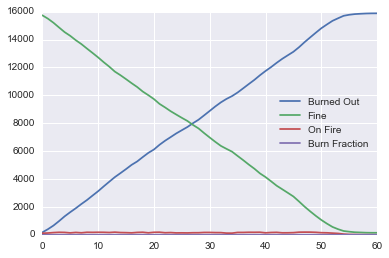

In [163]:
results.plot()

In the plot of the fraction of burned trees, we see that the fraction is much higher much faster, surpassing 20% by the tenth step. 

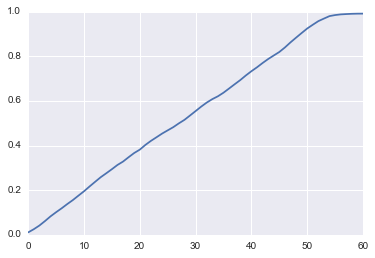

In [165]:
burn = results['Burn Fraction'].plot()

The fire spread very quickly, and ended quickly too. It took only 60 timesteps, and left only 145 trees unharmed. 

In [164]:
results.tail()

,Burned Out,Fine,On Fire,Burn Fraction
56,15821,183,18,0.987455
57,15845,168,9,0.988953
58,15864,152,6,0.990139
59,15874,145,3,0.990763
60,15877,145,0,0.990950


Let's look at some maps. We can see in the burned tree map that most of the area is covered. Nearly all of the tree have burnt, with the largest patch remaining being far from where the fire was initiated

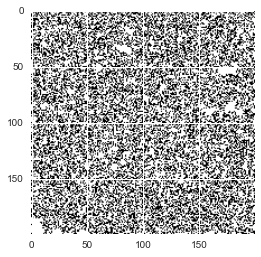

In [166]:
treeCounts = np.zeros((fire.grid.width, fire.grid.height))
for cell in fire.grid.coord_iter():
    cell_content, x, y = cell
    try:
        if cell[0].condition == "Burned Out":
            treeCount = 1
    except:
        treeCount = 0
    treeCounts[x][y] = treeCount
trees = plt.imshow(treeCounts)

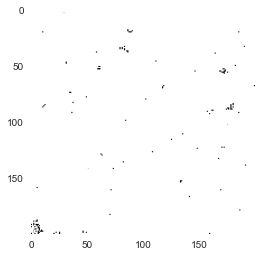

In [167]:
treeCounts = np.zeros((fire.grid.width, fire.grid.height))
for cell in fire.grid.coord_iter():
    cell_content, x, y = cell
    try:
        if cell[0].condition == "Fine":
            treeCount = 1
    except:
        treeCount = 0
    treeCounts[x][y] = treeCount
trees = plt.imshow(treeCounts)